# Portfolio Optimization Project

### CS/ECE/ISyE 524 — Introduction to Optimization — Fall 2024

### Project Members: Pawin Linmaneechote, Vincent Philavong, Jiajie Yao

## Table of Contents
1. Introduction  
    1.1. Project Motivation  
    1.2. Data Processing  
2. Mathematical Model  
    2.1 Minimum Volitaty Optimization (MVO) Model with L2 Regularlization (QP)  
    2.2 Markowitz Portfolio with Diversification (QP)  
    2.3 Sharpe Ratio with L2 Regularlization (NLP)  
3. Solution  
    3.1 Trade Off Analysis  
    3.2 Sensitivity Analysis  
4. Results and Discussion
5. Conclusion
6. Appendix
7. References

# 1. Introduction
## 1.1. Project Motivation
Investing is about making smart decisions to balance the trade-offs between risk and reward. In this project, we explore portfolio optimization by analyzing financial data from Yahoo Finance. We’ve chosen five asset sectors - Technology, Financials, Healthcare, Communication Services, and Industrials - to build a diversified portfolio. This selection spreads risk across industries while aiming to capture each sector’s growth potential. The list of the stock sectors and the individual stocks can be seen below.
- Technology
    - Apple (AAPL)
    - Uber (UBER)
    - Microsoft (MSFT)
    - NVIDIA (NVDA)
    - Advanced Micro Devices (AMD)
- Financial
    - Discover (DFS)
    - JP Morgan (๋JPM)
    - Synchrony (SYF)
    - American Express (AXP)
    - Goldman Sachs (GS)
- Health Care
    - Pfizer (PFE)
    - Johnson & Johnson (JNJ)
    - Merck Sharp & Dohme (MRK)
    - United Health Group (UNH)
    - ABBVie (ABBV)
- Communication Services
    - Meta (META)
    - Google (GOOG)
    - Netflix (NFLX)
    - T-Mobile (TMUS)
    - The Walt Disney Services (DIS)
- Industrials
    - Caterpillar (CAT)
    - RTX Coorporation (RTX)
    - The Boeing Company (BA)
    - Union Pacific Corperation (UNP)
    - Eaton Corporation PLC (ETN)

Our project focuses on optimizing three models. The first model, also known as the Minimum Volitaty Optimization (MVO), addressing the challenge of balancing variance in addition to diversification by analyzing the performance and relationships between the selected stocks. The second, known as the, Markowitz Model, builds on the baseline by of the variance model by tranforming the model into a trade-off between returns, variance, and diversification, which we believe will give a better result for the allocations. For the third model, we introduce a Sharpe Ratio model, focusing on maximizing the Sharpe Ratio with diversification to evaluate the effeciency of the stock allocations.

Portfolio optimization has been a topic of interest for investors and researchers for decades. It’s rooted in the uncertainty of financial markets, where both short-term gains and long-term stability needed careful evaluation. The economist, Harry Markowitz, revolutionized this field in 1952 with his paper Portfolio Selection, introducing diversification as a way to reduce risk (Team Investopedia, 2023). His work laid the groundwork for modern portfolio theory (MPT) and earned him a Nobel Prize. Yet, as markets continue to evolve, ongoing research is critical to adapting strategies for changing conditions like volatility, economic shifts, and new investor behaviors.

This report is structured into four sections: the Mathematical Model, where we define the decision variables, constraints, and objective function; the Solution, where we implement the model in Julia; Results and Discussion, where we present and interpret the outcomes; and the Conclusion, summarizing our findings and proposing future directions.

# 2. Mathematical Model

Portfolio optimization models can be designed in various ways by incorporating factors such as returns, variance, diversification, and other criteria. These models aim to provide practical insights for investors seeking to optimize their portfolios while understanding the implications of different investment strategies. Based on our dataset, we can formulate distinct models tailored to achieve specific objectives. In the following sections, we will outline the assumptions and motivations behind each model.

## 2.1 Assumptions

Our assumptions for this portfolio optimization is based on several key principles:

1. **Asset Returns**
- Normal Distribution: Asset returns are assumed to follow a normal distribution, meaning they exhibit predictable statistical behavior.
- Stationarity: Historical returns are representative of future returns (i.e., the underlying distribution remains constant over time).

2. **Risk (Variance)**
- Constant Variance: The variance of asset returns is constant over time.
- Independence or Correlation: The relationship between assets (covariance or correlation) is consistent and accurately captured by historical data.  
3. **Diversification**  
- No Over-concentration: Portfolios benefit from diversification, and spreading weights across multiple assets reduces unsystematic risk.  
- Trade-off Between Diversification and Return: A more diversified portfolio may lead to lower returns but reduced risk.

4. **Market Conditions**
- Efficient Markets: Markets are efficient, meaning that all relevant information is already reflected in asset prices.
- No Transaction Costs or Taxes: Models assume frictionless trading with no transaction costs, taxes, or liquidity constraints.

5. **Model Parameters**
- Risk Aversion Parameter (λ): The level of risk aversion is a known and fixed input, directly impacting the model's output.
- Weight Constraints: Asset weights are non-negative (no short selling) unless explicitly allowed.
- Portfolio weights sum to 1.

6. **Model Framework:**  
   - MVO: Risk is fully captured by variance, and investors care only about the mean and variance of returns.  
    - Markowitz: Linear relationships between returns and risk hold true across all asset combinations.  
    - Sharpe: The Sharpe model assumes that the Sharpe ratio would balance the risk and return for an investor-focused outcome
9. **Market Dynamics:**
    - We assume that market volatility is stable or fluctuate within a certain range during our analysis
10. **Investor Behavior:**
    - The models we use will assume a rational investor with the objective to maximize returns while minimizing risk.

## 2.2 Models   
Each model will have a different objective but will hold under these key frameworks:
1. **Diversification:** A key challenge in portfolio optimization is ensuring adequate diversification to protect against sector-specific or asset-specific risks. The penalty factor $\gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2$ encourages spreading the portfolio weights across multiple assets, thereby penalizing portfolios with excessive allocation to individual assets.
2. **Constraints:** Real-world constraints, such as bounds on individual asset weights $(0.02 \leq x_{i} \leq 0.10)$ and limits on sector allocations $(0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40)$, ensure the portfolio adheres to practical investment guidelines. These constraints align with the typical requirements of institutional investors to balance regulatory, sectoral, and diversification limits.
3. **Flexibility through γ:** The inclusion of the diversification penalty factor γ adds flexibility to the model, allowing users to tune the importance of diversification relative to risk minimization. For example:
    - A high γ value emphasizes diversification, favoring portfolios with evenly distributed weights.
    - A low γ value prioritizes risk minimization over diversification.

### 2.2.1 Minimum Volitaty Optimization Model with Diversification Term (QP)

The Minimum Volatility Optimization Model with Diversification Term (QP) is a quadratic program (QP) motivated by the need to balance risk minimization and diversification. As a QP, the model optimizes a quadratic objective function (portfolio variance and diversification penalty) subject to linear constraints on asset weights and sector allocations. By incorporating practical constraints and a tunable diversification penalty, the model ensures that portfolios are robust, well-diversified, and aligned with real-world investment goals, while leveraging the efficiency and mathematical rigor of quadratic programming techniques.

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $ \text{sector} $: Mapping of sectors to asset indices.


#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\}. $

#### Constraints:  
1. Bounds on Allocation  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}.
\end{aligned}
2. Budget Constraint
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1.
\end{aligned}
3. Sector Allocation Constraints
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

#### Objective Functions:
\begin{aligned}
\text{Minimize} \quad x^\top \Sigma x + \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}  
Where:
- $ x^\top \Sigma x $ : Portfolio variance (risk).  
- $ \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to promote diversification.


#### Final Model:
\begin{aligned}
\text{Minimize} \quad & x^\top \Sigma x + \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


### 2.2.2 Markowitz Portfolio with Diversification (QP)

The Markowitz Portfolio with Diversification Model (QP) is a sophisticated enhancement of the classical Markowitz framework. By adding a diversification penalty and introducing a risk aversion parameter, the model addresses the limitations of overly concentrated portfolios. Its quadratic programming (QP) formulation ensures efficient optimization while balancing return, risk, and diversification, making it a practical and robust tool for portfolio management.

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $ \text{sector} $: Mapping of sectors to asset indices.
- $\lambda $: Risk aversion parameter that controls the trade-off between return and risk.


#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\} $

#### Constraints:  
1. Bounds on Allocation  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}
\end{aligned}
2. Budget Constraint
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1
\end{aligned}
3. Sector Allocation Constraints
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}
\end{aligned}

#### Objective Function
\begin{aligned}
\text{Maximize} \quad \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}
Where:
- $ \mu^\top x $ : Expected return of the portfolio.
- $ x^\top \Sigma x $ : Portfolio variance (risk).
- $ \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to promote diversification.

#### Final Model
\begin{aligned}
\text{Maximize} \quad & \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


### 2.2.3 Sharpe Ratio with Diversification (QP)

The Sharpe Ratio with Diversification Model is motivated by the need to construct a portfolio that maximizes risk-adjusted returns while ensuring adequate diversification. The model is formulated as a nonlinear programming (NLP) problem because the Sharpe ratio involves nonlinear terms such as the portfolio standard deviation $\sqrt{x^\top \Sigma x}$ in the denominator. 

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $r_f$ Risk-free rate (set to 0 in this model)
- $ \text{sector} $: Mapping of sectors to asset indices.

#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\} $

#### Constraints:  
1. Bounds on Allocation  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}
\end{aligned}
2. Budget Constraint
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1
\end{aligned}
3. Sector Allocation Constraints
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}
\end{aligned}

#### Objective Function
\begin{aligned}
\text{Maximize} \quad \frac{\mu^\top x - r_f}{\sqrt{x^\top \Sigma x}} - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}
Where:
- $ \mu^\top x $ : Expected portfolio return.
- $ r_f $ : Risk-free rate.
- $ \sqrt{x^\top \Sigma x} $ : Portfolio standard deviation (risk).
- $ \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to encourage diversification.

#### Final Model
\begin{aligned}
\text{Maximize} \quad & \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


# 3. Solutions
In this section, we develop our portfolio optimization models using Julia and the JuMP package. To improve computational efficiency, we will utilize Ipopt solver. Each model is structured as a function, designed to accept input data through its arguments. This approach ensures flexibility and allows the models to be easily adapted to different data. At the beginning of each function, we provide clear documentation of the inputs, outputs, and the purpose of the implementation to promote usability and clarity.

## 3.1 Minimum Volitaty Optimization Model with Diversification (QP)

In [1]:
using CSV, DataFrames, Dates, Statistics, JuMP, Ipopt, PyPlot, LinearAlgebra

[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
[ Info: Precompiling Ipopt [b6b21f68-93f8-5de0-b562-5493be1d77c9]


In [2]:
#
# Input:
# γ: Diversification penalty factor to balance risk minimization and diversification
#
# Output:
# portfolio_weights: Optimal weights for each asset
# portfolio_return: Annual expected portfolio return
# portfolio_risk: Annual portfolio standard deviation (risk)
# sharpe_ratio: Risk-adjusted return of the portfolio
#
# Objective:
# Minimize portfolio variance with a diversification penalty term
#
function MVO(μ, Σ, γ)
    r_f = 0
    # Create optimization model
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Decision variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1) # Decision variable for asset allocation | asset allocation bounded in range(2%, 10%)

    # Constraints
    @constraint(m, sum(x) == 1) # Budget Constraints, ensures asset allocations are equal to 100%.
    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4) # Sector constraint bouned in range(10%, 40%).
    end

    # Objective
    @objective(m, Min, x' * Σ * x + γ * sum(x[i]^2 for i in 1:n_assets)) # Minimize Volitaty with a trade-off for diversification

    # Solve the model
    optimize!(m)
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Extract optimal portfolio weights
        portfolio_weights = value.(x)

        # Compute portfolio return and risk
        portfolio_return = μ' * portfolio_weights  # Annual expected return
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        println("Model infeasible")
    end
end

MVO (generic function with 1 method)

## 3.2 Markowitz Portfolio with Diversification (QP)

In [3]:
#
# Input:
# γ: Diversification penalty factor to promote balanced asset allocation
#
# Output:
# portfolio_weights: Optimal allocation weights for each asset
# portfolio_return: Annual expected portfolio return
# portfolio_risk: Annual portfolio standard deviation (risk)
# sharpe_ratio: Risk-adjusted return of the portfolio
#
# Objective:
# Maximize risk-adjusted return with a penalty for portfolio concentration
#
function Markowitz(μ, Σ, γ)
    # Create optimization model
    λ = 1
    r_f = 0
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Define variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)
    @constraint(m, sum(x) == 1)

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end


    @objective(m, Max, μ' * x - λ * (x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

    # Solve the model
    optimize!(m)

    # Check solution status
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = μ' * portfolio_weights  # Annual expected return
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        println("Model is infeasible.")
    end
end

Markowitz (generic function with 1 method)

## 3.3 Sharpe Ratio with Diversification (NLP)

In [4]:
#
# Input:
# γ: Diversification penalty factor to balance risk-adjusted return and portfolio concentration
#
# Output:
# portfolio_weights: Optimal allocation weights for each asset
# portfolio_return: Annual expected portfolio return
# portfolio_risk: Annual portfolio standard deviation (risk)
# sharpe_ratio: Risk-adjusted return (Sharpe Ratio) of the portfolio
#
# Objective:
# Maximize the Sharpe ratio with a penalty term for promoting diversification
#
function Sharpe(μ, Σ, γ)
    r_f = 0    # Risk-free rate
    
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Define variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)
    @constraint(m, sum(x) == 1)

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end

    # Objective function: maximize Sharpe ratio - γ * sum of squares of weights
    @objective(m, Max, (dot(μ, x) - r_f) / sqrt(x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

    # Solve the model
    optimize!(m)

    # Check the termination status
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = dot(μ, portfolio_weights)  # Annual expected return
        portfolio_risk = sqrt(dot(portfolio_weights, Σ * portfolio_weights))  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        println("Model is infeasible.")
    end
end

Sharpe (generic function with 1 method)

# 4. Results and Discussion

## 4.1 Data Processing

In [5]:
using CSV, DataFrames, Dates, Statistics, JuMP, Ipopt, PyPlot, LinearAlgebra

#= 
    Define current directory and read the CSV files
=#
directory_path = "data_files/"

# Initialize an empty DataFrame to hold daily returns of each asset
returns_df = DataFrame(Date = Date[])

# Read CSV file
for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)
        stock_name = splitext(basename(file))[1]
        stock_df[!, :DailyReturn] = [missing; diff(log.(stock_df.Close))]
        stock_returns = stock_df[:, [:Date, :DailyReturn]]
        rename!(stock_returns, :DailyReturn => stock_name)
        if nrow(returns_df) == 0
            returns_df = stock_returns
        else
            returns_df = outerjoin(returns_df, stock_returns, on = :Date)
        end
    end
end

# Remove rows with missing values
complete_cases = dropmissing(returns_df, disallowmissing=true)
CSV.write("complete_cases.csv", complete_cases)

#= 
    Extract Asset Names and Prepare Data
=#

col_names = names(complete_cases)

if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

asset_names = string.(asset_names)

# Extract the matrix of returns
returns_matrix = Matrix(complete_cases[:, asset_names])

# -- mapping sectors
# Load stock sheet and create sector mappings
stock_sheet = CSV.read("Stock Sheet.csv", DataFrame)

# Define the list of tickers in your portfolio
tickers = ["AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", 
           "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", 
           "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]

# Create a mapping from tickers to their sectors
ticker_to_sector = Dict(stock_sheet.Ticker .=> stock_sheet.StockSector)

# Check for missing sectors
missing_tickers = [ticker for ticker in tickers if !haskey(ticker_to_sector, ticker)]
if !isempty(missing_tickers)
    println("The following tickers are missing in the stock sheet: ", missing_tickers)
end

# Group indices by sector
sector_id = Dict()
for (i, ticker) in enumerate(tickers)
    if haskey(ticker_to_sector, ticker)
        sector = ticker_to_sector[ticker]
        if !haskey(sector_id, sector)
            sector_id[sector] = Int[]
        end
        push!(sector_id[sector], i)
    end
end

In [6]:
using DataFrames
using PrettyTables

# Function to define cumulative under a time period
function cumulative_return(returns, period)
    if length(returns) >= period
        exp(sum(returns[end-period+1:end])) - 1
    else
        missing
    end
end

# Define time periods in trading days
periods = Dict("1M" => 21, "6M" => 126, "1Y" => 252)

# Add a column for each time period's returns
summary_df = DataFrame(Asset = asset_names)

# Calculate returns for each asset
for period_name in keys(periods)
    period_days = periods[period_name]
    returns_by_period = Float64[]
    
    for asset in asset_names
        # Filter data for the asset
        returns = complete_cases[:, asset]
        push!(returns_by_period, cumulative_return(returns, period_days))
    end
    
    # Add to summary DataFrame
    summary_df[!, Symbol(period_name)] = returns_by_period
end

# Calculate full-time cumulative return
full_time_returns = [exp(sum(complete_cases[:, asset])) - 1 for asset in asset_names]
summary_df[!, :FullTime] = full_time_returns

# Format the returns as percentages with 2 decimal places
for col in names(summary_df)[2:end]  # Skip the "Asset" column
    summary_df[!, col] .= round.(summary_df[!, col] .* 100, digits=2)
end

function df_to_html(df::DataFrame)
    header = join(["<th>$name</th>" for name in names(df)], "")
    rows = join(["<tr>" * join(["<td>$col</td>" for col in row], "") * "</tr>" for row in eachrow(df)], "\n")
    """
    <table border="1" style="margin: auto; text-align: center;">
        <thead><tr>$header</tr></thead>
        <tbody>$rows</tbody>
    </table>
    """
end

function display_centered_df(df::DataFrame)
    html = df_to_html(df)
    display("text/html", html)
end

# Display the DataFrame
display_centered_df(summary_df)

Asset,6M,1Y,1M,FullTime
AAPL,22.51,26.49,0.79,247.46
ABBV,24.07,42.61,4.17,145.71
AMD,-8.27,26.2,-17.14,294.27
AXP,17.59,80.64,0.79,130.55
BA,-14.55,-22.58,-3.15,-57.37
CAT,11.12,59.24,-3.74,163.5
DFS,22.85,74.18,5.41,82.56
DIS,-8.31,13.59,4.59,-26.39
ETN,3.07,57.12,0.85,270.04
GOOG,-0.91,31.48,4.27,165.38


#### Inital Data Analysis [ask whether its the past month or the first month]

- **1-Month (1M)** : In the past month, Communication Services stood out as the best-performing sector, driven by strong gains from Netflix (NFLX, +8.83%). Nvidia (NVDA) led all stocks with the highest gain at +8.94%. The Health Care sector was the weakest, with Pfizer (PFE, -4.14%) and Merck (MRK, -6.39%) experiencing notable declines. The Industrial sector showed mixed results, with Eaton (ETN) posting a slight increase of +0.85%, while Boeing (BA) declined by -3.15%.
  
- **6-Month (6M)** : Over the last six months, Technology dominated, thanks to Nvidia's (NVDA) remarkable +54.5% gain. However, the sector also saw the largest loss, with Advanced Micro Devices (AMD) dropping -8.27%. The Financial sector showed strong progress, led by Discover (DFS, +22.85%) and JP Morgan (JPM, +15.51%). In contrast, the Health Care sector struggled the most, with Merck (MRK) performing poorly, falling by -22.04%.

- **1-Year (1Y)** : In the past year, Technology remained the top-performing sector, driven by Nvidia’s (NVDA) astounding growth of +210.88%. Other technology stocks, including AMD and Apple (AAPL), also performed well. Communication Services was the second-best sector, with significant gains from Meta (META, +81.95%) and Netflix (NFLX, +76.68%). The Financial sector also saw exceptional growth, with Synchrony (SYF, +88.46%) and Discover (DFS, +74.18%) as top performers. On the other hand, Industrials had mixed results: Eaton (ETN) achieved strong growth at +57.12%, but Boeing (BA) was the worst-performing stock, declining by -22.58%. Health Care also overall results, with ABBVie (ABBV) rising by +42.61%, Merck (MRK) and Pfizer (PFE) having declines by -1.67% and -10.46% respectively.

- **All Time (5Y)** : Over the five-year period, Technology was the most impressive sector, led by Nvidia's (NVDA) extraordinary rise of +2595.37%. Advanced Micro Devices (AMD, +294.27%) and Apple (AAPL, +247.46%) also contributed significantly. The Financial sector showed steady growth, with Goldman Sachs (GS, +141.26%) and American Express (AXP, +130.55%) leading the sector. Communication Services had a mixed performance: Netflix (NFLX, +164.7%) and Meta (META, +198.84%) posted strong growth, while Disney (DIS) declined by -26.39%. The Health Care sector remained stable, highlighted by ABBVie’s (ABBV) +145.71% growth, though Merck (MRK) and Pfizer (PFE) struggled. In Industrials, Eaton (ETN) was the best stock with +270.04% growth, while Boeing (BA) underperformed, falling by -57.37%. Across all sectors, Nvidia (NVDA) was the best-performing stock overall, while Boeing (BA) was the weakest.

Length of μ:25


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


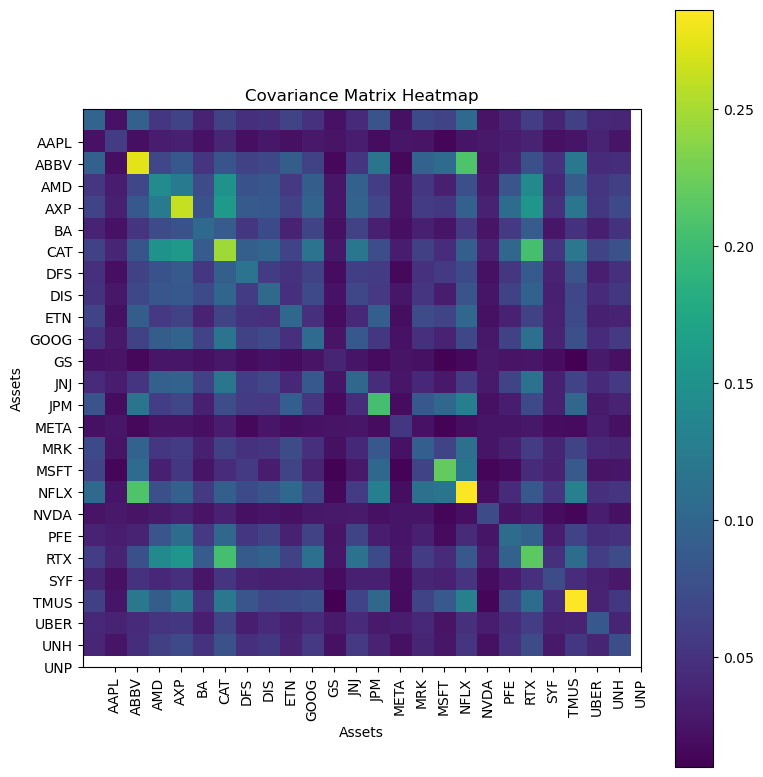

In [7]:
#= 
    Compute Expected Returns and Covariance Matrix ---
=#

trading_days = 252  

# Compute expected daily returns
μ_daily = mean(returns_matrix, dims=1)
μ_daily = vec(μ_daily) 

# Annualize expected returns
μ = (1 .+ μ_daily) .^ trading_days .- 1
println("Length of μ:", length(μ))

# Compute daily covariance matrix
Σ_daily = cov(returns_matrix, dims=1)

# Annualize covariance matrix
Σ = Σ_daily * trading_days

# Number of assets
n_assets = length(μ)

figure(figsize=(8, 8))
imshow(Σ, cmap="viridis")
colorbar()  # Add a colorbar to interpret values
title("Covariance Matrix Heatmap")
xlabel("Assets")
ylabel("Assets")
xticks(1:n_assets, asset_names, rotation=90)
yticks(1:n_assets, asset_names)
tight_layout()  # Adjust layout for better spacing
show()

## 4.3 Model Allocation Percentages Proportions for each Sector and Asset

The goal of this part is to analyze the allocation of sector weights in each optimization models (MVO, Markowitz, Sharpe) using visualized pie charts, so as to reveal the influence of each model on industry selection and diversification strategy. Comparing the industry distribution of different models helps to more intuitively understand their trade-offs in weight concentration and dispersion.  
  
Motivations include:  
1. Show the weighting priorities of different models in different industries.  
2. Compare the differences between the centralization and decentralization of the models in terms of industry weights.  
3. Three models (MVO, Markowitz, Sharpe) are used to explain the industry configuration characteristics driven by their respective optimization objectives.  


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



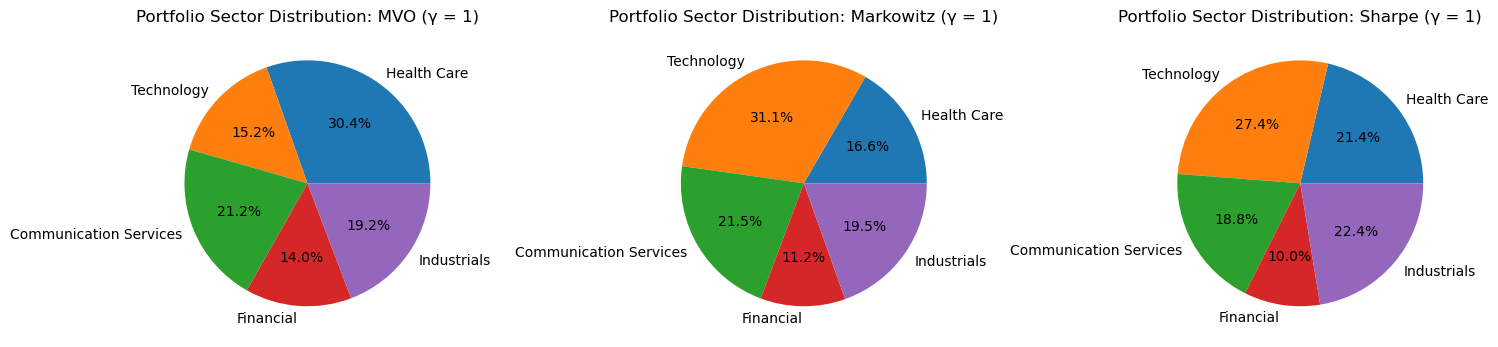

In [8]:
y = 1 # Gamma input
# Call the functions once and store the results
mvo_result = MVO(μ, Σ, y)
markowitz_result = Markowitz(μ, Σ, y)
sharpe_result = Sharpe(μ, Σ, y)

# Use the stored results to build the dictionary
portfolio_results = Dict(
    :MVO => (weights = mvo_result[1], ret = mvo_result[2], risk = mvo_result[3], sharperatio = mvo_result[4]),
    :Markowitz => (weights = markowitz_result[1], ret = markowitz_result[2], risk = markowitz_result[3], sharperatio1 = markowitz_result[4]),
    :Sharpe => (weights = sharpe_result[1], ret = sharpe_result[2], risk = sharpe_result[3], sharperatio = sharpe_result[4])
)


# --- Plotting Sector Weights for Each Model ---
model_order = [:MVO, :Markowitz, :Sharpe]

# Set up subplots: 1 row, number of models as columns
num_models = length(model_order)
fig, axes = subplots(1, num_models, figsize=(15, 6))  # Adjust figsize as needed

# Iterate through the models in the desired order
for (i, model_key) in enumerate(model_order)
    result = portfolio_results[model_key]
    
    # Calculate sector weights for the current model
    sector_weights = Dict()
    for (sector, indices) in sector_id
        total_weight = sum(result.weights[i] for i in indices)
        sector_weights[sector] = total_weight
    end

    # Plot pie chart on the corresponding subplot
    ax = axes[i]  # Select the subplot
    ax.pie(collect(values(sector_weights)), 
           labels=collect(keys(sector_weights)),
           autopct="%1.1f%%")
    title_text = "Portfolio Sector Distribution: $model_key (γ = $y)"
    ax.set_title(title_text)
    
end

# Adjust layout to prevent overlap and show the plots
tight_layout()
show()

#### Analysis Explanation

1. **MVO Model**
   - **Weight Distribution**: The weight distribution is more focused on Health Care (30.4%) with Communication Services (21.2%) accounting for a higher proportion, followed by Industrials (19.2%) and Technology (15.2%), and Financial (14.0%) accounting for the lowest proportion.
   - **Analysis**: The MVO model limits the concentration of sector weights through a penalty factor `γ` and emphasizes diversification, allocating more weight to low-volatility sectors (such as Health Care and Communications Services).

2. **Markowitz Model**
   - **Weight Distribution**: The weight is concentrated in the Technology sector (31.1%), with Communications Services (21.5%), Industrials (19.5%), Health Care (16.6%), and Financial (11.2%) accounting for the lowest share.
   - **Analysis**: The Markowitz model aims to maximize returns, with more weight assigned to high-return sectors (such as Technology), but with less decentralization and more concentration.

3. **Sharpe Ratio Model**
   - **Weight Distribution**: Skewed towards Technology (27.4%) and Health Care (21.4%), balanced by Industrials (22.4%) and Communications Services (18.8%), and lowest in Financial (10.0%).
   - **Analysis**: The Sharpe ratio model balances returns and diversification in optimizing risk-adjusted returns, favoring high Sharpe ratio industries while maintaining some industry diversity.


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


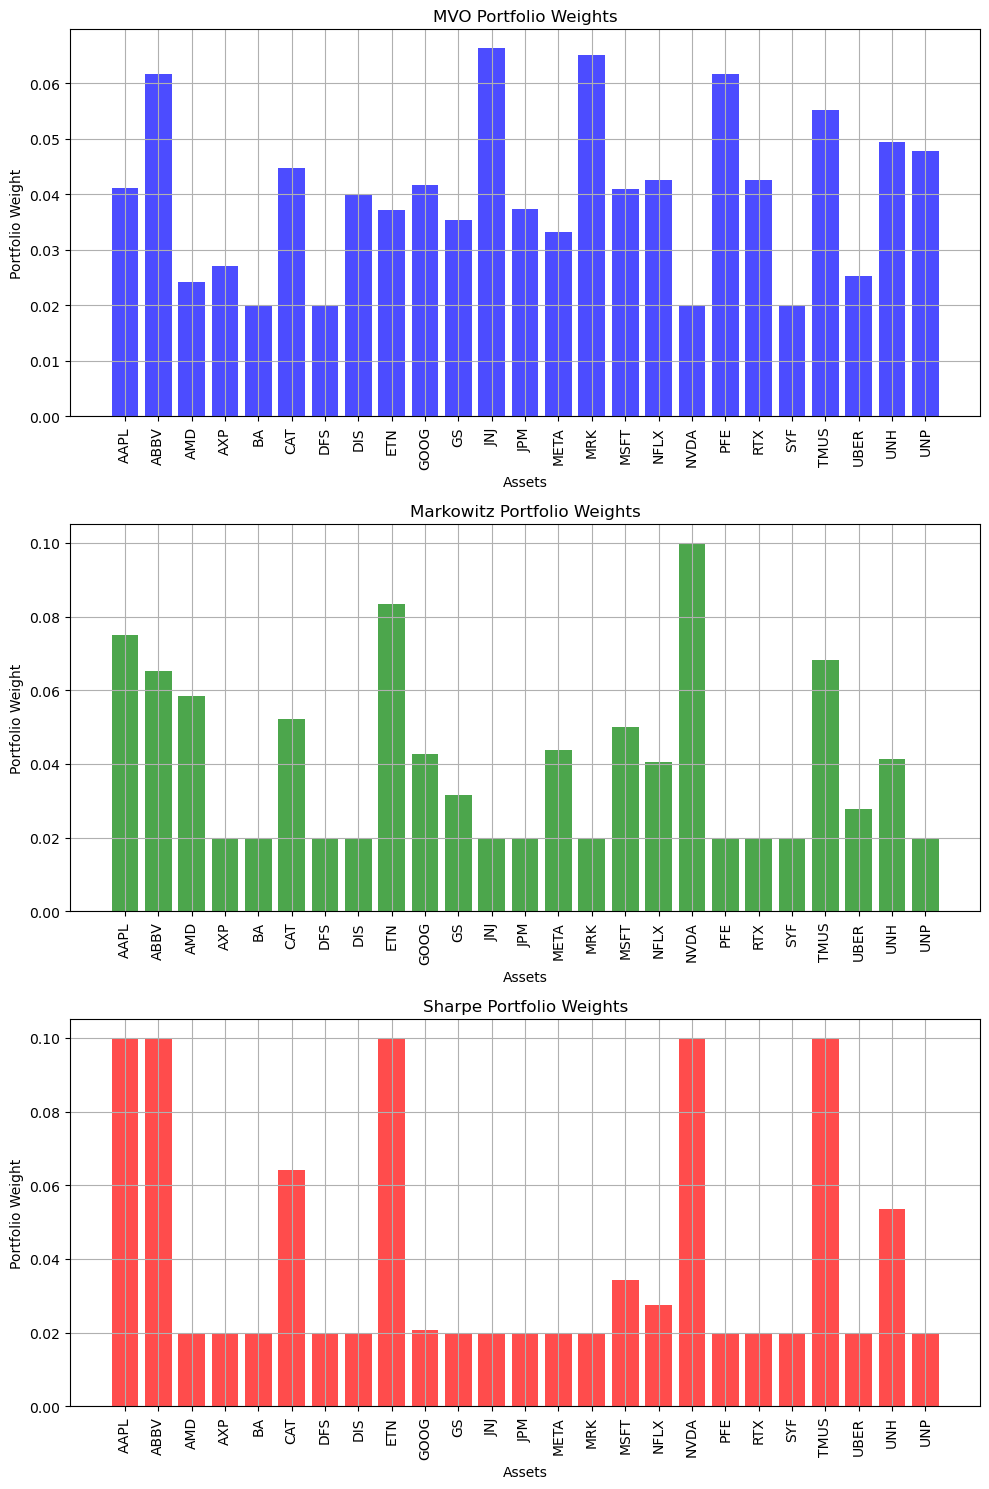

In [9]:
figure(figsize=(10, 15))  # Adjust the figure size for a vertical layout

# Colors for different portfolios
portfolio_names = collect(keys(portfolio_results))
model_order = [:MVO, :Markowitz, :Sharpe]
colors = ["blue", "green", "red"]  # Ensure the number of colors matches the number of portfolios

# Plotting the weights for each portfolio
for (i, model_key) in enumerate(model_order)
    subplot(length(portfolio_results), 1, i)  # Change to vertical layout
    portfolio_weights = portfolio_results[model_key][:weights]
    bar(1:n_assets, portfolio_weights, color=colors[i], alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("$model_key Portfolio Weights")
    grid(true)
    tight_layout()
end

show()


#### Analysis 

1. **MVO Model** : The MVO model exhibits the most balanced and diversified portfolio. This is evident from the relatively even distribution of asset weights, with most weights falling within the 4% to 6% range and very few assets at the minimum weight of 2%. An interesting find was that all of the Health Care assets having the highests due to the correlation to other sectors being low.
2. **Markowitz Model** : Compared to the MVO model, the Markowitz model is less diversified. There are more assets at the minimum investment level of 2%, indicating a higher concentration of weights in fewer assets.
3. **Sharpe Ratio Model**: The Sharpe Ratio model demonstrates the least diversification among all models. The portfolio is heavily concentrated in a few high-equity assets, as seen in the sharp peaks where weights reach a maximum of 10%, while the majority of assets remain at the minimum investment of 2%.

## 4.4 Cumulative Weight Distribution Analysis

#### Cumulative Weight Distribution Analysis

The goal of this part is to visualize the weight allocation of each optimization model to stock assets through the cumulative weight distribution diagram. This helps to further understand the priority and diversification characteristics of each model in asset selection. Different models' trade-offs between risk and return can lead to differences in stock weight distributions, which reflect the model's optimization strategy and actual effects.

- **Motivations include:**
  1. **Weight Ordering and Prioritization**: The cumulative distribution of weights after visual ordering can clearly show how weights are assigned by different models.
  2. **Centralization versus Decentralization**: Observe whether the model's weight distribution of assets is concentrated on a small number of high-weight assets, or distributed across multiple assets.
  3. **Differences Between Models**: Compare the similarities and differences in the cumulative weight distribution of the three models to reveal their different preferences for return and diversification.


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


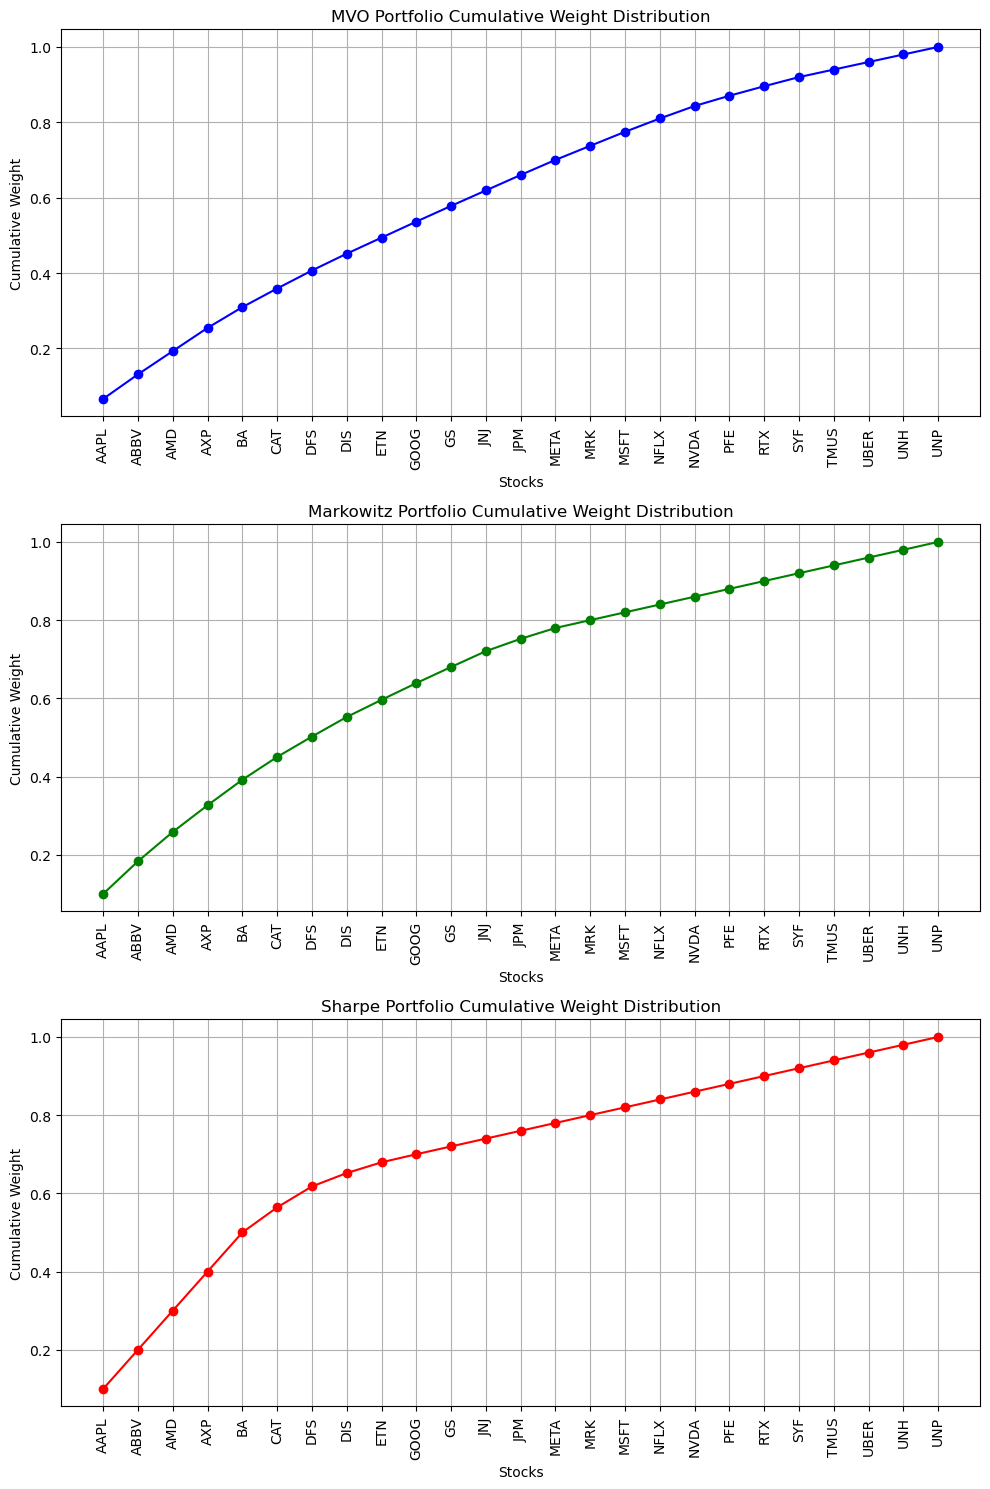

In [10]:
# --- Plotting Sector Weights for Each Model ---
model_order = [:MVO, :Markowitz, :Sharpe]
colors = ["blue", "green", "red"]

# Set up subplots: 1 row, number of models as columns
num_models = length(model_order)
figure(figsize=(10, 15)) 

# Iterate through the models in the desired order
for (i, model_key) in enumerate(model_order)
    subplot(length(portfolio_results), 1, i)
    portfolio_weights = portfolio_results[model_key][:weights]
    
    # Sort weights and calculate cumulative distribution
    sorted_weights = sort(portfolio_weights, rev=true)
    cumsum_weights = cumsum(sorted_weights)

    # Plot cumulative distribution
    plot(1:length(sorted_weights), cumsum_weights, color=colors[i], marker="o", linestyle="-", label=model_key)
    xticks(1:length(sorted_weights))
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Stocks")
    ylabel("Cumulative Weight")
    title("$model_key Portfolio Cumulative Weight Distribution")
    grid(true)
    tight_layout()
    show()
end



#### Analysis and Interpretation

- **Code Logic**:
  1. **Data Processing**:
     - The code first extracts the stock weights for each model from the optimization results.
     - Ranks stocks by weight from highest to lowest, ensuring that assets with higher weights appear first in the cumulative distribution.
  2. **Plotting**:
     - Three subgraphs are generated, corresponding to the cumulative weight distribution of the MVO model, Markowitz model, and Sharpe model, respectively.
     - Each subgraph uses a different color (blue, green, red) to distinguish the models, and the stock labels are rotated for clear display.

- **Result Analysis**:
  1. **MVO Model**:
     - **Distribution Characteristics**: The cumulative weight curve increases most gently, indicating that the weight distribution is more uniform. The weight of a single stock is low, and the weight difference between all stocks is small.
     - **Analysis**: The MVO model emphasizes decentralization, limiting the weight of a single asset through the `γ` parameter, so that the weight distribution is more uniform. This results in the gentlest accumulation curve of the three.
     - **Limitation**: The MVO model focuses too much on minimizing risk, possibly at the expense of potentially high-yielding assets.
  2. **Markowitz Model**:
     - **Distribution Characteristics**: The cumulative weight curve rises rapidly in the first few stocks, showing that some stocks (such as NFLX and AXP) have significantly higher weights. The weight of subsequent stocks decreases rapidly (e.g., PFE and BA) and is unevenly distributed.
     - **Analysis**: The Markowitz model is more focused on maximizing returns and therefore may tend to assign more weight to assets with high earnings expectations.
     - **Limitation**: Because the weighting is concentrated in a small number of high-return assets, the portfolio is riskier and vulnerable to the performance of a single asset.
  3. **Sharpe Ratio Model**:
     - **Distribution Characteristics**: The cumulative weight curve is steepest, indicating a concentration in a small number of high-risk-adjusted return assets (e.g., NFLX and UBER).
     - **Analysis**: The Sharpe ratio model allocates more weight to assets with higher Sharpe ratios by optimizing risk-adjusted returns while appropriately taking diversification into account.
     - **Limitation**: The weight distribution is still too concentrated. Although both risk and return are considered, it relies heavily on high-risk-adjusted return assets and may ignore the potential of low-risk assets.

- **Comparison**:

| Model            | Diversification | Weight Concentration | Accumulation Curve Characteristics                      | Type of Investor Applicable                                |
|------------------|-----------------|----------------------|---------------------------------------------------------|----------------------------------------------------------|
| **MVO Model**    | High            | Lowest               | Smooth and gradual growth, indicating uniform distribution | Risk-averse investors who seek stable returns            |
| **Markowitz Model** | Medium         | High                 | Rapid growth in the first few stocks, uneven distribution | High-return-oriented, risk-tolerant investors            |
| **Sharpe Model** | Low             | Highest              | Steep curve, concentrated on a few high Sharpe ratio assets | Investors who seek risk-adjusted returns and prefer high returns |


## 4.5 Diversification Sensitivity Analysis

This analysis explores the behaior of portfolio returns and variances under varying levels of diversifcation penalties (𝛾), also know as regularlizato. The goal is to provide insights into how the different optimization models — Mean-Variance Optimization (MVO), Markowitz Optimziation, and the Sharpe Ratio Maximization — responds to changes in 𝛾 and how these repsonses manifest in terms of portfolio performance metrics.

Our key motivation for this analysis:
1. **Understanding Diversification Effects:**  
γ acts as a parameter for the diversification penalty described in each of our models, representing how much weight is placed on diversifying our portfolio. By analyzing varying values of 𝛾, we aim to observe how portfolios adabt in terms of return and variance across all 3 models
2. **Model Comparisions:**  
While all three models are grounded in optimization principles, their formulations lead to differeing portfolio composisions. This analysis seeks to compare the performances of each model and understand their suitability for differing market conditions
3. **Polynomial Fitting for Trend Insights:**  
The financial markets often exhibit nonlinear behaviors, and fitting a polynomial to the return and variance data provides a smooth representation of trends. This approach helps identify key patterns andoutliers that might not be evident from numerical data alone.
4. **Practical Applications:**  
For portfolio managers, understanding how different optimization frameworks repsonds to risk penalities aids in constructing portfolios that align with strategic investment goals.

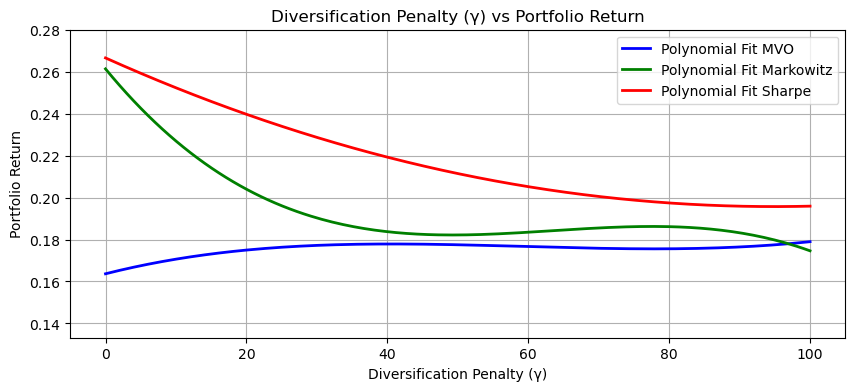

In [11]:
γ_values = 0:1:100
models = ["MVO", "Markowitz", "Sharpe"]
results = []

# Define colors for models
model_colors = Dict("MVO" => "blue", "Markowitz" => "green", "Sharpe" => "red")

# Collect results for each model and γ
for model in models
    for γ in γ_values
        port = eval(Symbol(model))(μ, Σ, γ)  # MVO and Sharpe use only γ
        if !isnothing(port)
            portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio = port
            portfolio_variance = portfolio_risk^2  # Variance is the square of risk
            push!(results, (model, γ, portfolio_return, portfolio_variance))
        end
    end
end

# Create subplots for Portfolio Return and Portfolio Variance
figure(figsize=(10, 4))

# Plot 1: Portfolio Return
for model in models
    # Filter results for the current model
    model_results = filter(r -> r[1] == model, results)
    γ_vals = [r[2] for r in model_results]
    ret_vals = [r[3] for r in model_results]

    # Fit a polynomial to the data
    degree = 3
    X = hcat([γ_vals.^k for k in degree:-1:0]...)
    coeffs = X \ ret_vals

    # Polynomial function
    poly_fit = x -> sum(coeffs[i] * x^(degree - i + 1) for i in 1:length(coeffs))

    # Scatter plot and fitted polynomial
    scatter(γ_vals, ret_vals, alpha=0, color=model_colors[model])
    x_fit = range(minimum(γ_vals), stop=maximum(γ_vals), length=200)
    y_fit = [poly_fit(x) for x in x_fit]
    plot(x_fit, y_fit, label="Polynomial Fit $model", lw=2, color=model_colors[model])
end
xlabel("Diversification Penalty (γ)")
ylabel("Portfolio Return")
title("Diversification Penalty (γ) vs Portfolio Return")
legend()
grid(true)

### 4.5.1 Return Analysis

- **<span style="color:blue;">MVO (Blue)</span>**
The portfolio return starts relatively low at around 16% annually, but it shows a slight upward trend as γ increases. This suggests that increasing diversification penalties initially lead to slightly better returns. However, as γ increases further, the return stabilizes and converges to approximately 18% annually.  
  
- **<span style="color:green;">Markowitz (Green)</span>**
The return initially starts high at 26% annually, but as γ increases, the returns decrease rapidly and eventually converge to about 18% annually. This indicates that increasing diversification penalties lead to lower returns.  
  
- **<span style="color:red;">Sharpe (Red)</span>**
The return starts high at around 26% annually, but as γ increases, it gradually decreases and stabilizes at approximately 20% annually. This suggests that increasing diversification penalties lead to lower returns, but the impact is more moderate compared to the Markowitz model.



When comparing all these models we see that returns are most stable with the MVO model, possibly because there is no term in the objective function that maximizes the returns. As for the Markowitz and Sharpe model, they follow the same trend in decreasing returns as it is diversified. Decreasing trends in returns does not necessarily mean the portfolio selected by the model is bad as we do not know the variance of each function as its diversification parameter increases. In our next analysis we will analyze the variances in comparison to diversification.

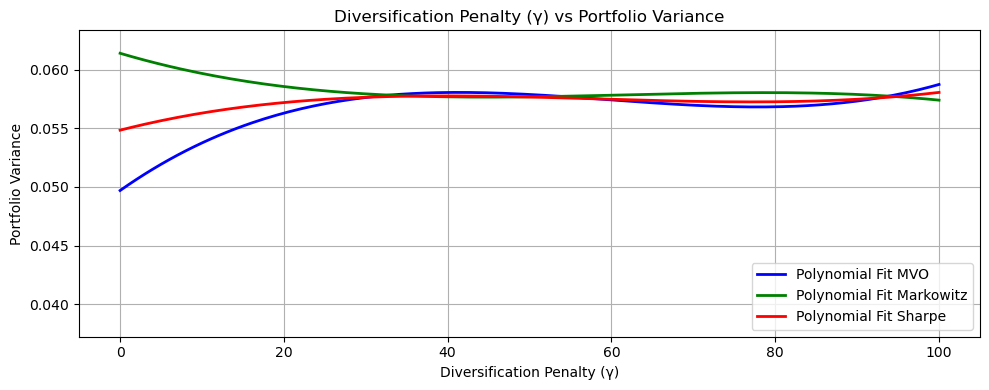

In [12]:
figure(figsize=(10, 4))

for model in models
    # Filter results for the current model
    model_results = filter(r -> r[1] == model, results)
    γ_vals = [r[2] for r in model_results]
    variance_vals = [r[4] for r in model_results]

    # Fit a polynomial to the data
    degree = 3
    X = hcat([γ_vals.^k for k in degree:-1:0]...)
    coeffs = X \ variance_vals

    # Polynomial function
    poly_fit = x -> sum(coeffs[i] * x^(degree - i + 1) for i in 1:length(coeffs))

    # Scatter plot and fitted polynomial
    scatter(γ_vals, variance_vals, alpha=0, color=model_colors[model])
    x_fit = range(minimum(γ_vals), stop=maximum(γ_vals), length=200)
    y_fit = [poly_fit(x) for x in x_fit]
    plot(x_fit, y_fit, label="Polynomial Fit $model", lw=2, color=model_colors[model])
end
xlabel("Diversification Penalty (γ)")
ylabel("Portfolio Variance")
title("Diversification Penalty (γ) vs Portfolio Variance")
legend()
grid(true)

# Adjust layout and show the plots
tight_layout()
show()

### 4.5.2 Variance Analysis

- **<span style="color:blue;">MVO (Blue)</span>**
In this model, we observe a low variance of approximately 0.05 when the value of γ is small. As γ increases, the variance gradually rises, eventually converging to about 0.057 at γ = 40. This observation indicates that as the portfolio becomes more diversified, the variance increases.
  
- **<span style="color:green;">Markowitz (Green)</span>**
The variance starts high with this model at approximately 0.062 when γ is small. As γ increases, the variance decreases, eventually converging to around 0.057 at γ = 40, which aligns closely with the MVO model. This suggests that as the portfolio becomes more diversified, the variance reduces.

  
- **<span style="color:red;">Sharpe (Red)</span>**
The variance starts at a moderate level, between the Markowitz and MVO models, at approximately 0.055 when γ is small. As γ increases, the variance shows a slight upward trend, eventually converging to around 0.057 at γ = 40. This indicates that the Sharpe model demonstrates stability across both small and large γ values.



When comparing all these models, we observe that the variance for small γ values follows the order: MVO < Sharpe < Markowitz. While there are noticeable differences in variance for small γ values, as γ increases, all models converge to a variance of approximately 0.057. This level of variance is considered favorable for the selected assets, as it reflects the high value these assets bring, inherently resulting in higher variance.

## 4.4 Efficient Frontier

# 5. Conclusion

## 5.1 Project Summary

In this project, we dove into three distinct investment strategies: MVO, Markowitz, and Sharpe Ratio. Each model offers a unique approach to balancing risk and reward, while also considering portfolio diversification.

The MVO model is a cautious approach, prioritizing risk minimization over maximizing returns. This leads to a well-diversified portfolio, spreading investments across various assets to reduce overall risk. The Markowitz model, on the other hand, is more aggressive, aiming to maximize risk-adjusted returns. This can result in a more concentrated portfolio, with a larger portion of the investment allocated to a few high-performing assets. The Sharpe Ratio model also focuses on risk-adjusted returns, but it tends to produce highly concentrated portfolios. This strategy can yield significant returns, but it also comes with increased risk.

By analyzing these models and their sensitivity to diversification penalties, we can see that the optimal strategy depends on an investor's risk tolerance and investment goals. A risk-averse investor might prefer the MVO model, while a more aggressive investor could lean towards the Markowitz or Sharpe Ratio models. Ultimately, the key is to find a balance between risk and reward that aligns with individual financial objectives.

## 5.2 Future Direction

One promising direction for future research is to integrate machine learning techniques to enhance the accuracy of return and risk forecasts. By leveraging historical data, we can extract meaningful features, model time series patterns, and employ techniques like linear regression, random forests, and gradient boosting. These improved forecasts can then be integrated into our existing portfolio optimization models to create more adaptive portfolios that can navigate the unpredictability of the market. We can then compare the performance of portfolios optimized with these machine learning-enhanced forecasts to those optimized with traditional methods.

# 6. References

- Team, T. I. (2023, August 29). Modern portfolio theory: What MPT is and how investors use it. Investopedia. https://www.investopedia.com/terms/m/modernportfoliotheory.asp?utm_source=chatgpt.com 